In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.manifold import TSNE
from umap import UMAP

from MulticoreTSNE import MulticoreTSNE as mTSNE
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

# change to %matplotlib notebook to rotate plots
%matplotlib notebook 
plt.rcParams.update({'font.size': 20, 'axes.titley':1})

# Merged

In [3]:
data = defaultdict(dict)

RARITY_THRESHOLD = 0.01
STD_THRESHOLD = 1e-3

tax = 'g'
df_AGP = pd.read_csv(f'./data_processed/AGP_{tax}.csv', delimiter=',', index_col=0)
df_HMP = pd.read_csv(f'./data_processed/HMP_{tax}.csv', delimiter=',', index_col=0)

n_AGP = df_AGP.shape[0]
n_HMP = df_HMP.shape[0]
y = np.zeros(n_AGP + n_HMP)
y[n_AGP:] = 1
df = pd.merge(df_AGP, df_HMP, how = 'outer', sort=True).fillna(0)
N = df.shape[0]
# too rare
rare_otu_mask = ((df > 0).sum(0) / N) < RARITY_THRESHOLD
# too low std
std_otu_mask = df.std(0) < STD_THRESHOLD
mask = rare_otu_mask * std_otu_mask
df_proc = df.iloc[:,~mask.values]

# t-SNE

In [4]:
tsne = mTSNE(n_components=3, 
            perplexity=35,
            angle=0.5, 
            early_exaggeration=18,
            n_jobs=-1, 
            n_iter=1000,
            random_state=42)

Z_tsne = tsne.fit_transform(df_proc)
np.save(f'./tsne_3d_merged_tax-{tax}', Z_tsne)

In [5]:
lof_mask = LocalOutlierFactor(n_neighbors=30, contamination=0.1).fit_predict(Z_tsne) == 1

<IPython.core.display.Javascript object>


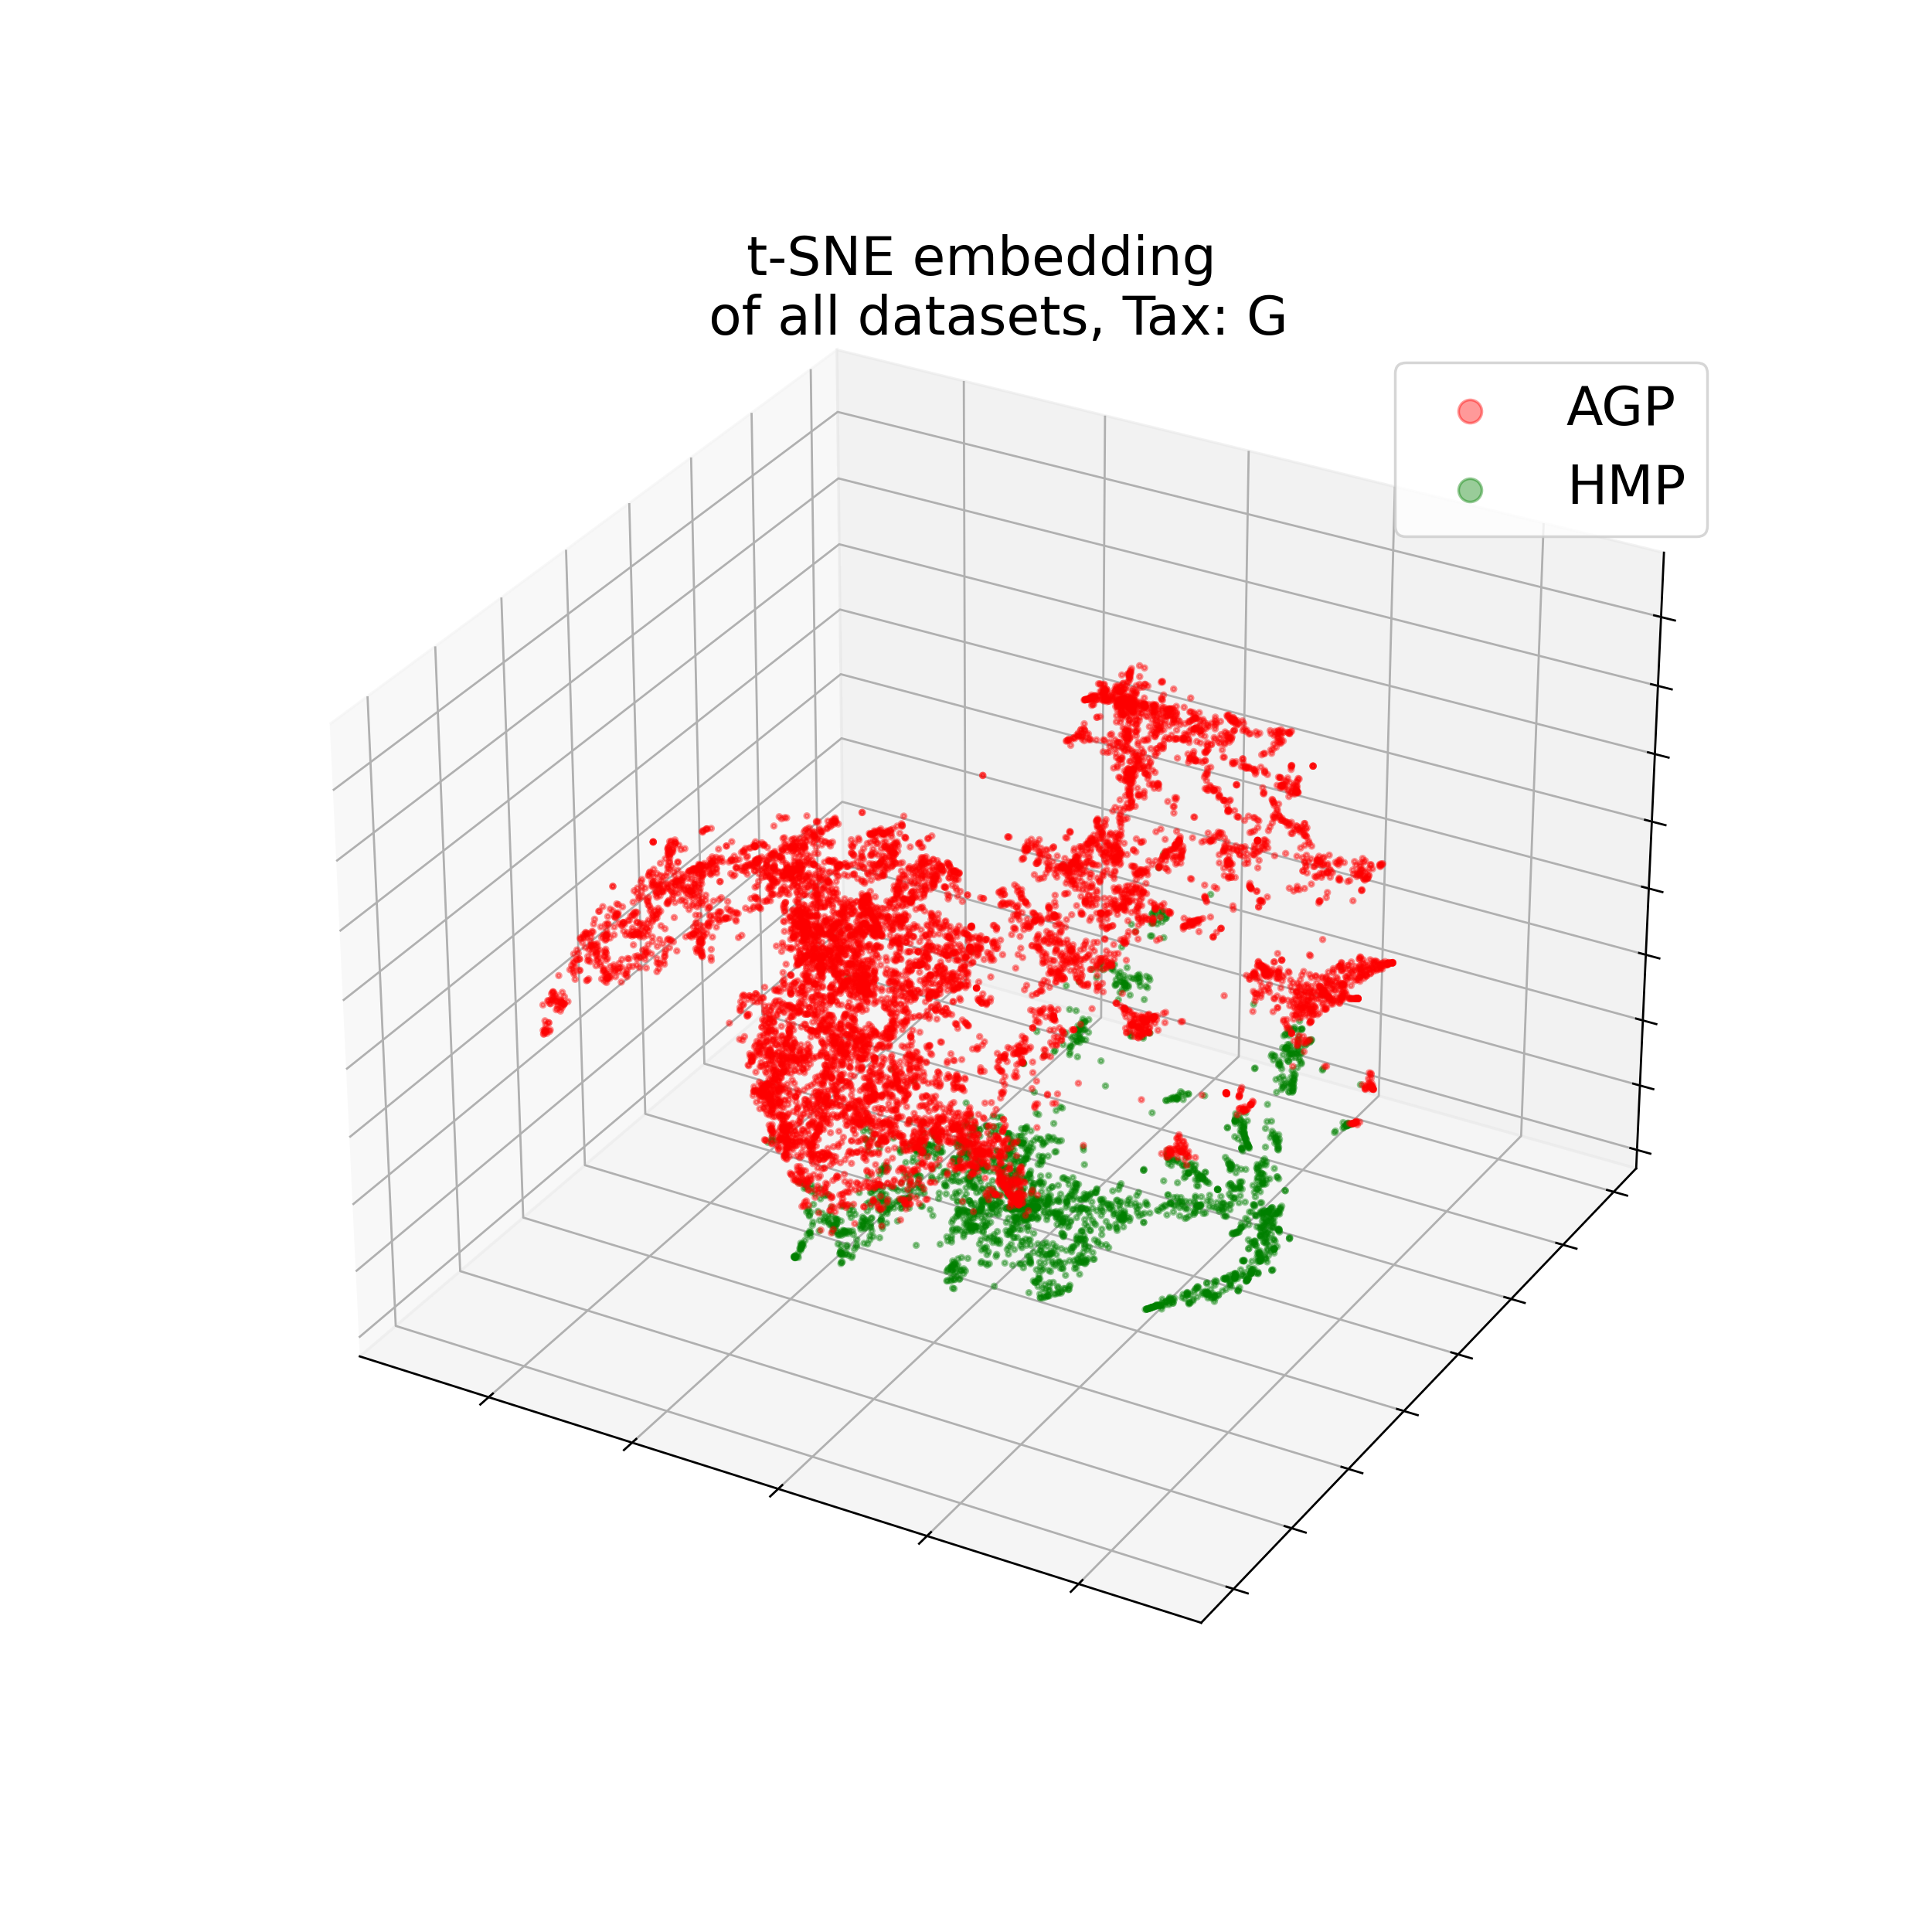

In [19]:
fig = plt.figure(figsize=(10,10), dpi=200)
ax = plt.axes(projection="3d")
Z = Z_tsne[lof_mask]
AGP_mask = np.arange(Z.shape[0]) < 9511
ax.scatter3D(Z[:, 0][AGP_mask], Z[:, 1][AGP_mask], Z[:, 2][AGP_mask], color = 'red', s = 3, label='AGP', alpha=0.4)
ax.scatter3D(Z[:, 0][~AGP_mask], Z[:, 1][~AGP_mask], Z[:, 2][~AGP_mask], color = 'green', s = 3, label='HMP',alpha=0.4)
plt.title(f"t-SNE embedding \n of all datasets, Tax: {tax.capitalize()}", fontsize=20)
plt.legend(markerscale=5, bbox_to_anchor=(1.0, 0.93)) 
ax.set_zticklabels([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(True)
ax.view_init(67, -149) # 67, -149

# ax.view_init(-39, 21) # 67, -149
plt.show()

In [7]:
Z_umap = UMAP(n_neighbors=40, 
              n_components=3,
              n_epochs=1000,
              min_dist=0.0, 
              learning_rate=1, 
              n_jobs=-1,
              random_state=42).fit_transform(df_proc)
np.save(f'./umap_3d_merged_tax-{tax}', Z_tsne)

In [16]:
lof_mask = LocalOutlierFactor(n_neighbors=30, contamination=0.15).fit_predict(Z_umap) == 1

<IPython.core.display.Javascript object>


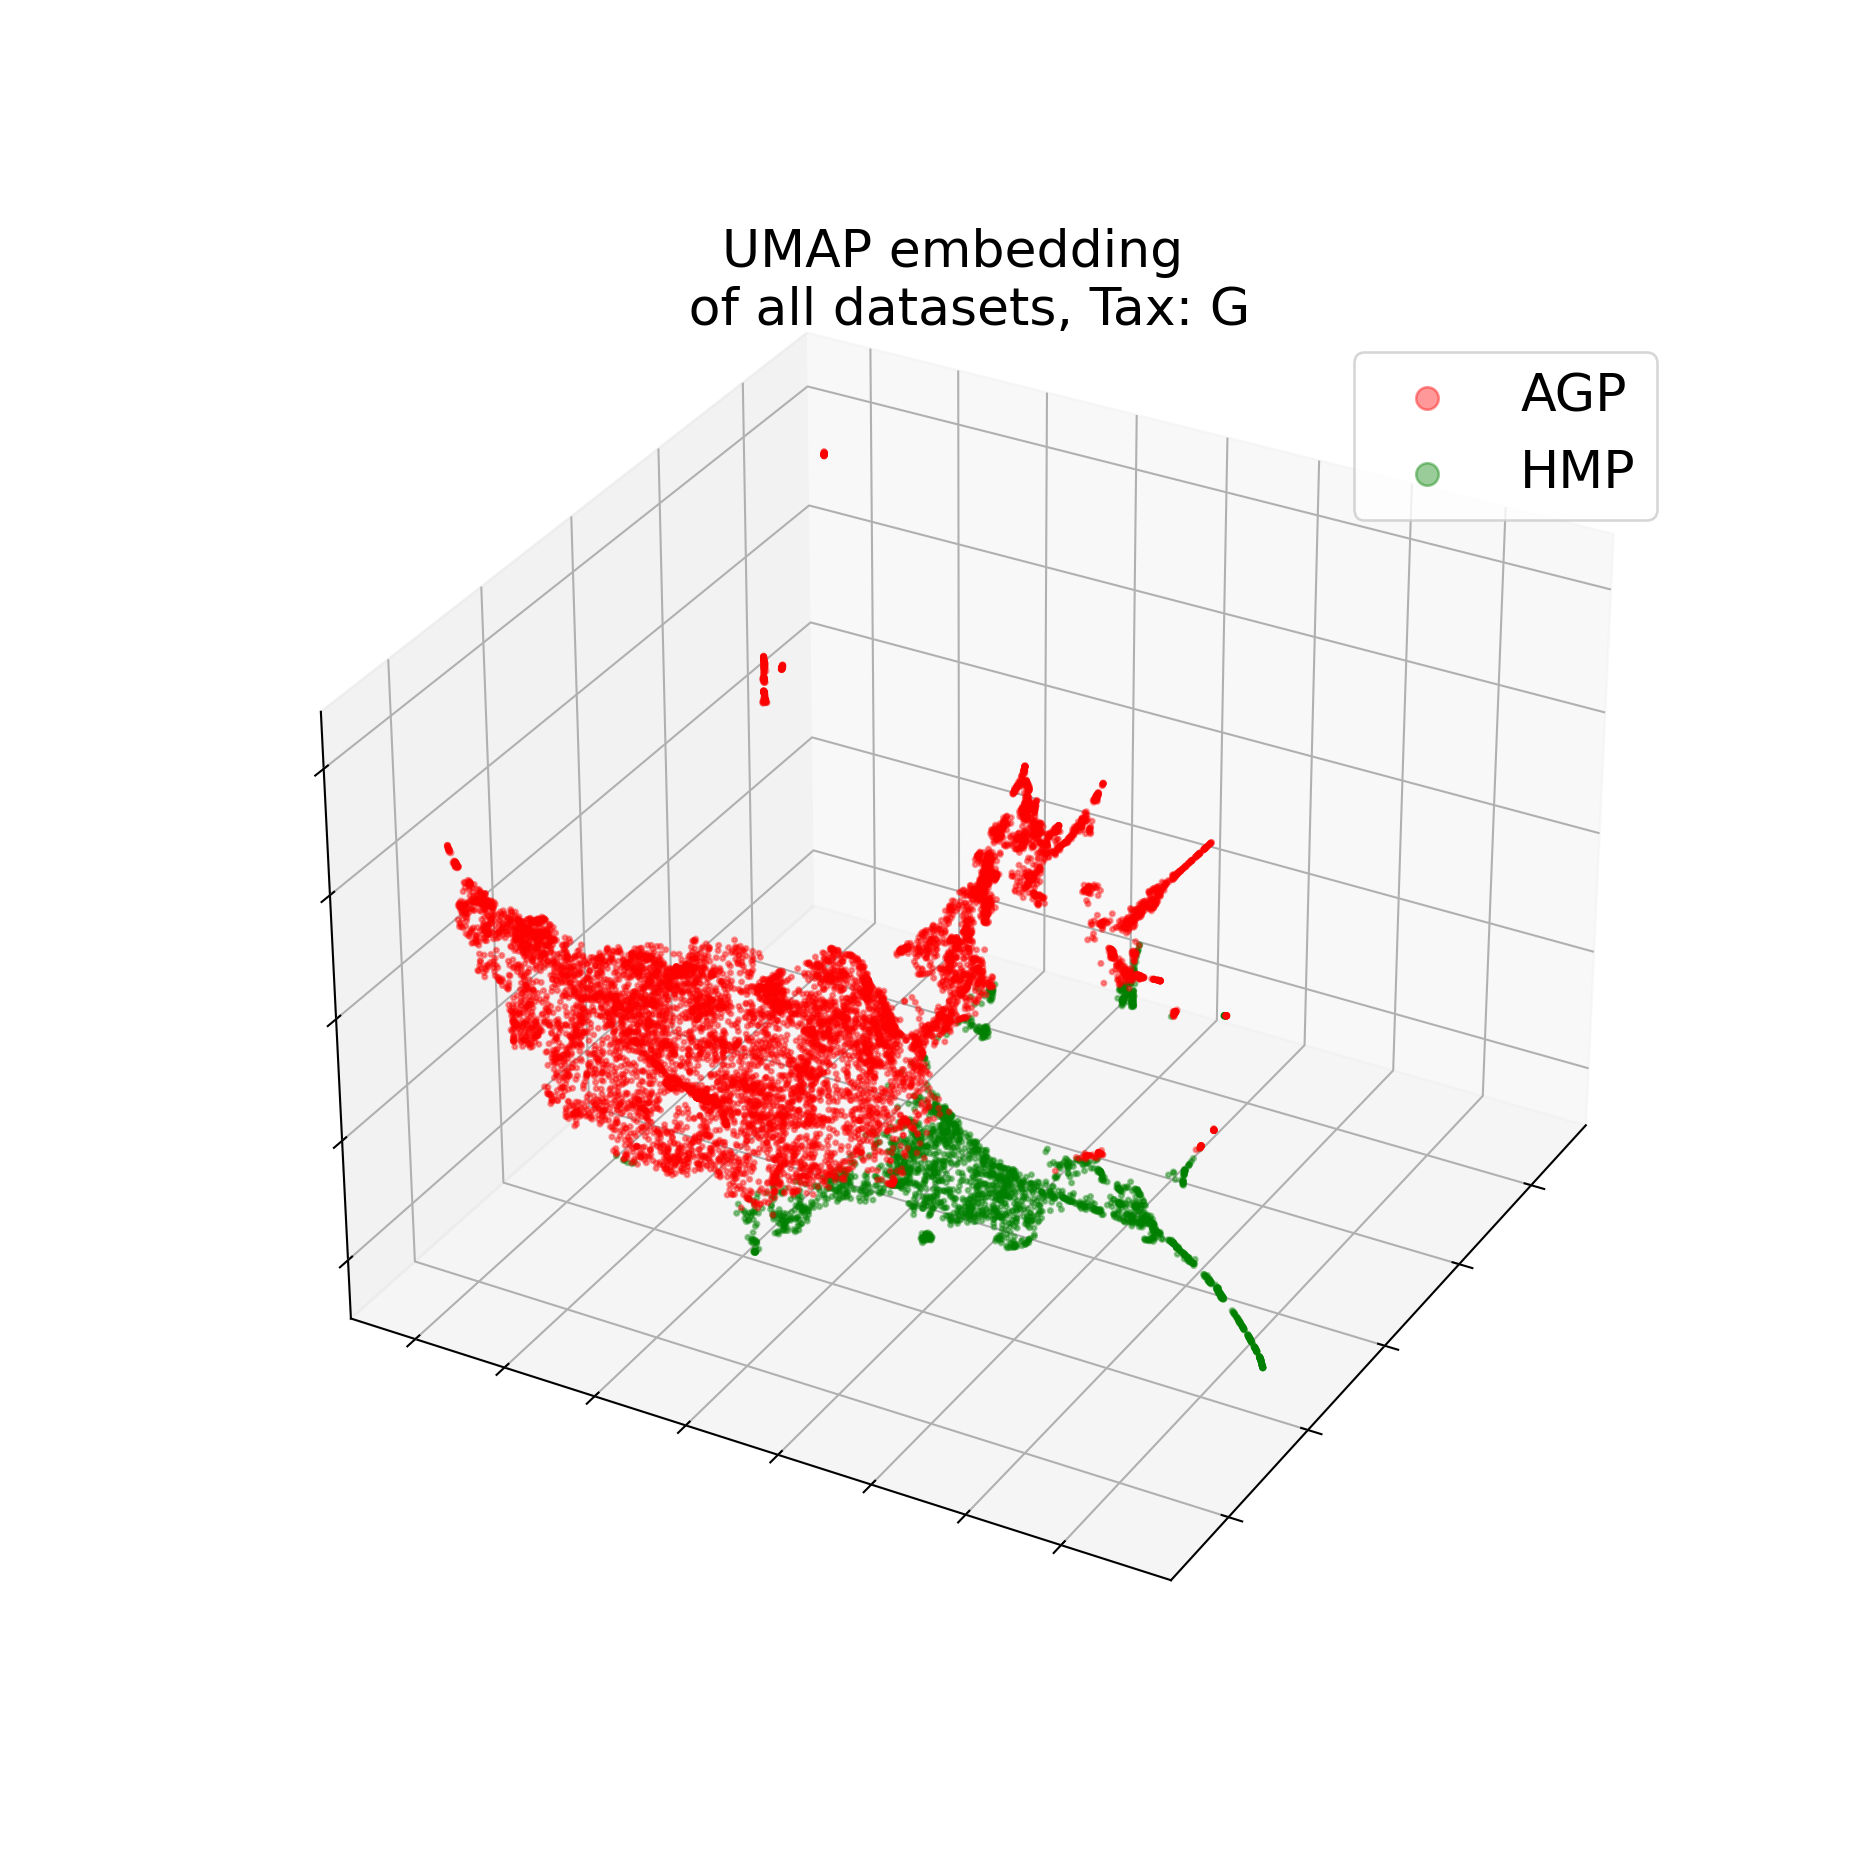

In [23]:
fig = plt.figure(figsize = (10,10), dpi=200) 
ax = plt.axes(projection ="3d")
Z = Z_umap[lof_mask]#['f']
AGP_mask = np.arange(Z.shape[0]) < 9511
ax.scatter3D(Z[:, 0][AGP_mask], Z[:, 1][AGP_mask], Z[:, 2][AGP_mask], color = 'red', s = 3, label='AGP', alpha=0.4)
ax.scatter3D(Z[:, 0][~AGP_mask], Z[:, 1][~AGP_mask], Z[:, 2][~AGP_mask], color = 'green', s = 3, label='HMP',alpha=0.4)
plt.title(f"UMAP embedding \n of all datasets, Tax: {tax.capitalize()}", fontsize=20)
plt.legend(markerscale=5, bbox_to_anchor=(1.0, 0.93))
ax.set_zticklabels([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(True)
ax.view_init(-39, 21)
plt.show()